<a href="https://colab.research.google.com/github/Almonfrey/MAI-Course/blob/main/class_8_underfitting_vs_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCI Heart Disease — MLP Underfitting vs Overfitting

This notebook recreates and documents the supplied code that demonstrates underfitting and overfitting using the **UCI Heart Disease (Cleveland)** dataset and `sklearn`'s `MLPClassifier`.

**Goals:**
- Provide a clean, well-documented Jupyter-style notebook version of the code.
- Split the work into logical parts (imports, data loading, cleaning, preprocessing, modeling, evaluation, plotting).
- Explain *why* each step is done and what alternatives / caveats exist (important for medical data).

---

## Notes on usage
- This is a *static* notebook (code cells are ready to run in a Jupyter environment). It does not execute here — run the cells in your environment (e.g., Jupyter Lab, Jupyter Notebook, VS Code) to get results and plots.
- If you want, I can export this to a runnable `.ipynb` file next.

## 1 — Imports and environment setup

### Whats is done?
- `pandas`, `numpy`: for data handling.
- `sklearn` modules: for splitting, preprocessing, modeling, and metrics.
- `matplotlib`: for plotting learning curves.
- `warnings`: to silence convergence warnings (MLP often warns if not fully converged each epoch).
- We use `warm_start=True` in `MLPClassifier` to manually control epochs and record accuracy at each step.

### Why these imports?
- **pandas / numpy**: core for reading and manipulating tabular data.
- **train_test_split, cross_val_score, StratifiedKFold**: tools to measure generalization and to create train/test splits preserving class balance.
- **Pipeline / ColumnTransformer**: ensure preprocessing is fitted only on training data — avoids leakage and keeps code tidy.
- **SimpleImputer / StandardScaler / OneHotEncoder**: common preprocessing steps for missing values, scaling continuous features, and encoding categorical ones.
- **MLPClassifier**: a feed-forward neural network. It's flexible and demonstrates capacity changes that produce under/overfitting behaviors.


In [1]:
# 1. Importing libraries
# Standard data tools
import pandas as pd            # dataframes (tabular data handling)
import numpy as np             # numerical operations

# Model selection and model building
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

# Preprocessing building-blocks
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifier and evaluation
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Plotting
import matplotlib.pyplot as plt

## 2 — Load and clean the UCI Heart Disease (Cleveland) dataset

### Notes about the dataset
- This dataset is widely used for classification examples. The `target` column in the original dataset is **0** for no disease and **1-4** for presence (different degrees). We convert to binary.
- The raw file uses `?` as a placeholder for missing values in some columns (particularly `ca` and `thal`).

In [2]:
# 2. Load ORIGINAL UCI Heart Disease Cleveland dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
    "oldpeak","slope","ca","thal","target"
]

df = pd.read_csv(url, names=columns)

# Quick look (uncomment when running interactively)
# display(df.head())
# display(df.info())

## 3 — Cleaning procedures

### What is done?
- Load the original dataset from UCI.
- Replace "?" with NaN so sklearn imputation can handle missing data.
- Convert all columns to numeric: ensures correct dtypes for preprocessing.
- Convert `target` to binary: original has 0 (no disease), 1-4 (presence of disease), so we map >0 to 1.

### Detailed explanation
- `df.replace("?", np.nan)`: the dataset uses `?` where data is missing — converting to `np.nan` allows `pandas`/`sklearn` imputation utilities to work.
- `pd.to_numeric(errors='coerce')`: forces columns to numeric dtype; any value that cannot be parsed becomes `NaN`. This normalizes heterogeneous types (strings + numbers).
- After conversion we print missing counts so we can decide imputation strategy per column.
- **Target conversion**: the dataset encodes disease severity with integers 0–4; turning it into a binary target (0 vs. 1) is typical when the task is disease *presence* detection.

Caveat: for more nuanced risk modeling you could treat the problem as *ordinal* or *multiclass* rather than binary.

In [3]:
# 3. Cleaning procedures
# Replace "?" with np.nan
df.replace("?", np.nan, inplace=True)

# Convert all columns to numeric, forcing errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Target variable: 0 (absence), 1-4 (presence). Convert to binary classification.
# Using replace keeps the intention of the original code; an equivalent is: (df['target'] > 0).astype(int)
df['target'] = df['target'].replace({1:1, 2:1, 3:1, 4:1})

# A quick sanity check for target class balance (uncomment when running):
# print(df['target'].value_counts(normalize=True))

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


## 4 — Separate features and target

**What is done?**
- `X`: predictors; `y`: outcome (disease presence).
- This separation is standard for supervised learning.

In [4]:
# 4. Separate features and target
X = df.drop('target', axis=1)
y = df['target']

## 5 — Identify numerical and categorical columns

### What is done?
- Some features are truly categorical (`cp`, `restecg`, `slope`, `ca`, `thal`).
- Others are numerical.
- Categorical features will be one-hot encoded; numerical features will be scaled.
- This setup lets the neural network treat all features appropriately.

### Detailed explanation

The original code treats `cp`, `restecg`, `slope`, `ca`, and `thal` as categorical. That's reasonable because:
- `cp` (chest pain type) has a few discrete codes.
- `restecg` (resting electrocardiographic results) is discrete-coded.
- `slope` is the slope of the peak exercise ST segment (discrete categories).
- `ca` is the number of major vessels (0–3) but often stored with missing values and small integer domain — one-hot encoding is typical.
- `thal` originally contains values referencing distinct categories (and `?` in raw data).

We'll follow the same categorization for the pipeline below.

In [5]:
# 5. Identify numerical and categorical columns: 'ca' and 'thal' are categorical
cat_cols = ['cp', 'restecg', 'slope', 'ca', 'thal']
num_cols = [col for col in X.columns if col not in cat_cols]

# For interactive inspection (uncomment to inspect):
# for c in cat_cols:
#     print(c, df[c].unique())

### Remarks on column types
- Some columns (e.g., `ca`) are integer-valued but limited to a few categories; converting them to categorical avoids assuming ordinal/continuous relationships.
- If you believe `ca` should be treated as ordinal (0 < 1 < 2 < 3), alternatives are `OrdinalEncoder` or keeping it numeric.

## 6 — Train/test split
### What is done?
- 70% training, 30% test, stratified by `y` (preserves class balance).
- Fixed random state for reproducibility.

### Why stratify and random_state?
- **Stratify** ensures that the proportion of positive/negative cases is similar in both train and test. This is especially important when classes are imbalanced.
- **random_state** makes the split reproducible: the same code will produce the same split, useful for debugging and comparisons.

In [6]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

## 7 — Build preprocessing pipeline (imputation, scaling, encoding)

### What is done?
- Use `ColumnTransformer` to apply appropriate preprocessing to each column type.
- **Numerical**: impute missing values (mean) and standardize (zero mean, unit variance).
- **Categorical**: impute missing values (most frequent) and one-hot encode.
- *Why pipeline?*: Ensures preprocessing is applied identically during fit and predict, and prevents data leakage.

In [7]:
# 7. Build preprocessing pipeline (imputation, scaling, encoding)
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

### Detailed explanation
- **Numerical pipeline**:
  - `SimpleImputer(strategy='mean')`: replaces missing numeric values with column mean. This is simple and robust for small amounts of missingness but may be suboptimal if missingness is informative.
  - `StandardScaler()`: MLPs converge much faster when inputs are standardized (mean 0 and unit variance). Neural networks are sensitive to feature scaling.

- **Categorical pipeline**:
  - `SimpleImputer(strategy='most_frequent')`: fills missing categories with the most common category. Alternatives: a new category label like 'missing' or a separate missing indicator.
  - `OneHotEncoder(handle_unknown='ignore')`: encode categories as binary columns. `handle_unknown='ignore'` prevents errors at inference time if unseen categories appear in test data.

**Why use ColumnTransformer + Pipeline?**
- Keeps the preprocessing steps encapsulated and ensures they are applied consistently during cross-validation and test set predictions.
- Prevents data leakage: `fit` is only called on training data when using `cross_val_score` or `GridSearchCV` with the pipeline.

## 8 — Define a Helper Function to Train an MLP, Record and Plot Accuracy per Epoch

### What is done?
- Use `warm_start=True` in `MLPClassifier` to iteratively train for 1 epoch at a time.
- After each epoch, record train and test accuracy.
- This allows us to plot how accuracy evolves during training.

In [8]:
# 8. Helper function to train, record and plot accuracy per epoch.
def train_accuracy_curve(hidden_layer_sizes, model_name,
                         early_stopping, n_epochs, batch_size):
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        early_stopping=early_stopping, n_iter_no_change=10,
                        tol=1e-4, max_iter=500, warm_start=True,
                        batch_size=batch_size, random_state=42)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    train_acc = []
    test_acc = []

    for epoch in range(n_epochs):
        pipe.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, pipe.predict(X_train)))
        test_acc.append(accuracy_score(y_test, pipe.predict(X_test)))

    plt.figure(figsize=(8,5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.title(f'Accuracy per Epoch — {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()
    print(f'{model_name} — Final epoch: Train Accuracy: {train_acc[-1]:.3f}, Test Accuracy: {test_acc[-1]:.3f}')

## 9 — Run Helper Function to Train and Plot Learning Curves for all Models

## What is done?

- We run three models:
  - **Underfit**: Very small network (1 neurons). Can't capture data patterns well.
  - **Balanced**: Medium-sized network (100 neurons, `alpha=0.01`, `adam` solver, `learning_rate_init=0.001`). Tends to generalize better.
  - **Overfit**: Large network (two layers of 1000 neurons). Can memorize training data, but may not generalize.
- Compare their learning curves to see underfitting/overfitting visually.

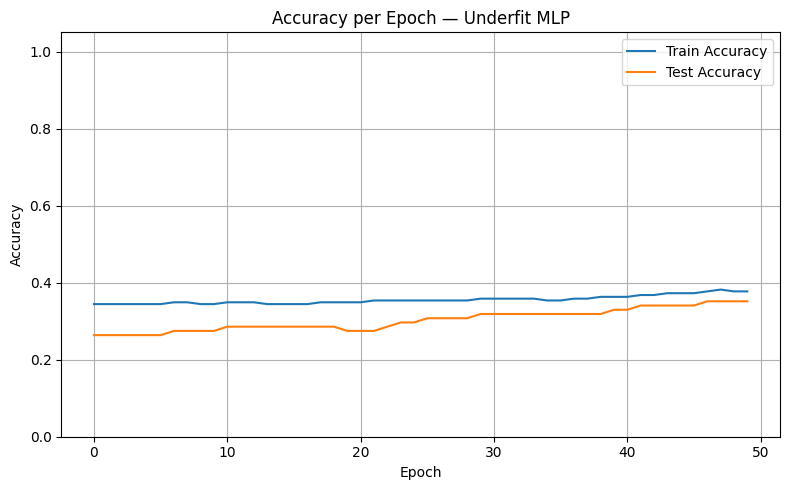

Underfit MLP — Final epoch: Train Accuracy: 0.377, Test Accuracy: 0.352


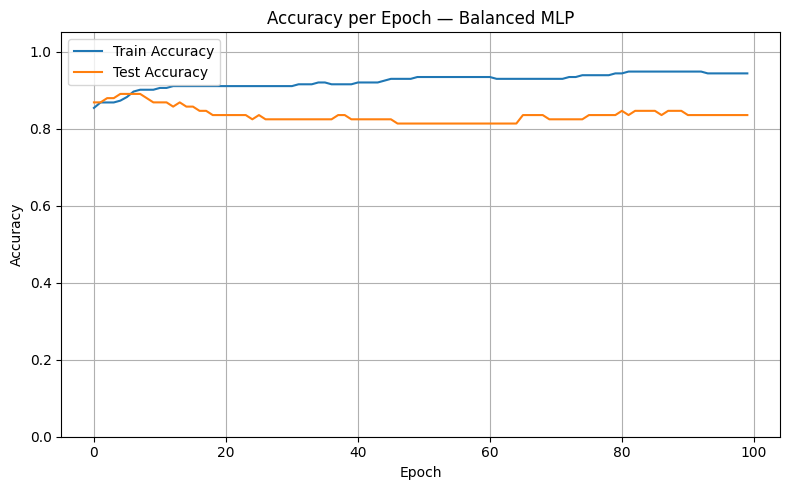

Balanced MLP — Final epoch: Train Accuracy: 0.943, Test Accuracy: 0.835


In [ ]:
# 9. Run helper function
# Underfit
train_accuracy_curve((1,), 'Underfit MLP',
                     early_stopping=True,
                     n_epochs=50, batch_size='auto')

# Balanced
train_accuracy_curve((100, 100), 'Balanced MLP',
                     early_stopping=True,
                     n_epochs=100, batch_size=32)

# Overfit
train_accuracy_curve((512, 512, 256, 128), 'Overfit MLP',
                     early_stopping=True,
                     n_epochs=1000, batch_size=4)

## 9 — Interpreting the Curves & Next Steps

**What and Why?**
- **Underfit:** Train/test accuracy are both low and don't improve much — the model can't capture the complexity of the data.
- **Balanced:** Both accuracies rise and plateau at similar values — good fit.
- **Overfit:** Training accuracy may rise much higher than test accuracy, which plateaus or drops — the model memorizes training data.
- If your balanced model plateaus at low test accuracy, try tuning `alpha`, `hidden_layer_sizes`, or use early stopping, or alternative models.